# PYTHON CONTROL LIBRARY

This notebook is an exploration of key elements of the control library.

# Preliminaries

In [2]:
import numpy as np
import pandas as pd
import tellurium as te
import control as c
import matplotlib.pyplot as plt

# Basics

In [21]:
# Simple system
A = -0.7*np.identity(2)
B = np.reshape(np.array([1, 0]), (2,1))
C = np.reshape(np.array([1, 1]), (1, 2))
D = 0
sys = c.StateSpace(A, B, C, D)
sys

StateSpace(array([[-0.7, -0. ],
       [-0. , -0.7]]), array([[1.],
       [0.]]), array([[1., 1.]]), array([[0.]]))

In [25]:
np.linalg.inv(A)*B

array([[-1.42857143, -0.        ],
       [-0.        , -0.        ]])

In [10]:
# Does this look right?
c.series(sys, sys)


StateSpace(array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 1., 0.],
       [0., 0., 0., 1.]]), array([[1.],
       [0.],
       [0.],
       [0.]]), array([[0., 0., 1., 1.]]), array([[0.]]))

In [11]:
c.parallel(sys, sys)

StateSpace(array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1.],
       [0.],
       [1.],
       [0.]]), array([[1., 1., 1., 1.]]), array([[0.]]))

In [12]:
c.feedback(sys)

StateSpace(array([[ 0., -1.],
       [ 0.,  1.]]), array([[1.],
       [0.]]), array([[1., 1.]]), array([[0.]]))

In [13]:
c.ss2tf(sys)

TransferFunction(array([ 1., -1.]), array([ 1., -2.,  1.]))

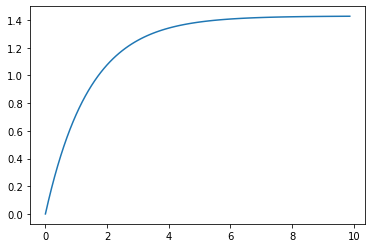

In [22]:
t = c.step_response(sys)
plt.plot(t.time, t.outputs)

# Create Nonlinear System

In [26]:
def predprey_rhs(t, x, u, params):
    # Parameter setup
    a = params.get('a', 3.2)
    b = params.get('b', 0.6)
    c = params.get('c', 50.)
    d = params.get('d', 0.56)
    k = params.get('k', 125)
    r = params.get('r', 1.6)

    # Map the states into local variable names
    H = x[0]
    L = x[1]

    # Compute the control action (only allow addition of food)
    u_0 = u if u > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

In [27]:
io_predprey = c.NonlinearIOSystem(
    predprey_rhs, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

In [30]:
timev = list(range(10))
inputv = np.repeat(1, len(timev))
X0 = [5, 5]
t, y = c.input_output_response(io_predprey, timev, inputv, X0, {})

In [31]:
[(tv, ty) for tv, ty in zip(t, y)]

[(0,
  array([  5.        ,  37.95216684,  99.55348089, 110.95292882,
          98.5867469 ,  67.85585067,  19.86812571,   2.46745573,
           1.14593559,   2.05224533])),
 (1,
  array([ 5.        ,  4.52389506,  7.8342813 , 16.65608212, 35.06939509,
         66.93242859, 91.46188532, 67.50732493, 40.79367961, 24.57910553]))]

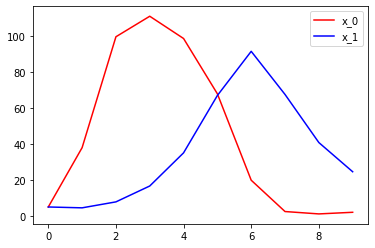

In [44]:
_, ax = plt.subplots(1)
ax.plot(t, y[0], c="red")
ax.plot(t, y[1], c="blue")
ax.legend(["x_0", "x_1"])

# Antimony Simulation as a Nonlinear System

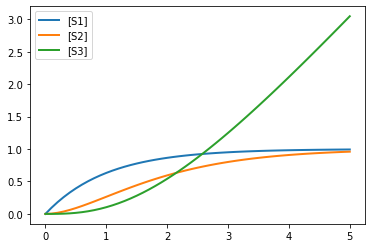

In [45]:
MODEL = """
-> S1; k1
S1 -> S2; k2*S1
S2 -> S3; k3*S2

k1 = 1
k2 = 1
k3 = 1
S1 = 0
S2 = 0
S3 = 0
"""
rr = te.loada(MODEL)
data = rr.simulate()
rr.plot()

In [5]:
# Differential equation for states S1, S2, S3
def linear_pathway_rhs(time, states, inputs, params):
    STATES = ["S1", "S2", "S3"]
    # Parameter setup
    k1 = params.get('k1', 1.0)
    k2 = params.get('k2', 1.0)
    k3 = params.get('k3', 1.0)

    # Set values for states, considering initial conditions
    if (time == 0) or (states is None):
        state_dct = {n: 0 for n in range(len(STATES))}
    else:
        state_dct = {"k%d": states[n] + 1 for n in range(len(states))}
        
    # Compute derivates of state
    dS1 = k1 * state_dct["k1"]
    dS2 = k2 * state_dct["k2"]
    dS3 = k3 * state_dct["k3"]

    return [dS1, dS2, dS3]

# Tests
params = {"k1": 1.0, "k2": 1.0, "k3": 1.0}
result = linear_pathway_rhs(0, None, None, params)
result

KeyError: 'k1'